# Attention Visualized

## Configuration

In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'

# Model
MODEL_NAME = "Qwen/Qwen3-1.7B"
MODEL_DTYPE = "bfloat16"
TEMPERATURE = 0.6
MAX_SEQ_LEN = 32768

# GPU assignment
VLLM_GPU = 0
TRANSFORMERS_GPU = 1

# Attention
ATTENTION_LAYER = -1  # -1 = last layer, or set to specific index (e.g. 27)
EPSILON = 0.00001
SIGMOID_TEMPERATURE = 2.0

# Prompts
SYSTEM_PROMPT = "You are a helpful assistant."
USER_MESSAGE = r"Given a rational number, write it as a fraction in lowest terms and calculate the product of the resulting numerator and denominator. For how many rational numbers between 0 and 1 will $20_{}^{}!$ be the resulting product?"

# Font
FONT_PATH = "./_inventory/fonts/SFPRODISPLAYREGULAR.OTF"

print(f"Model: {MODEL_NAME}")
print(f"GPU Assignment: vLLM={VLLM_GPU}, Transformers={TRANSFORMERS_GPU}")
print(f"Attention layer: {ATTENTION_LAYER} (resolved after model load)")

Model: Qwen/Qwen3-1.7B
GPU Assignment: vLLM=0, Transformers=1
Attention layer: -1 (resolved after model load)


## Imports & Setup

In [18]:
%matplotlib inline
import re
import torch
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
from matplotlib.patches import Rectangle
from transformers import AutoTokenizer, AutoModelForCausalLM
from vllm import LLM, SamplingParams
import warnings
warnings.filterwarnings('ignore')

if torch.cuda.device_count() < 2:
    raise RuntimeError(f"Need at least 2 GPUs, got {torch.cuda.device_count()}")

plt.ioff()
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.grid'] = False

if os.path.exists(FONT_PATH):
    fm.fontManager.addfont(FONT_PATH)
    fontname = fm.FontProperties(fname=FONT_PATH).get_name()
    matplotlib.rcParams['font.family'] = fontname
else:
    matplotlib.rcParams['font.family'] = 'sans-serif'

## Load Models

In [3]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

print(f"[1/2] Loading vLLM on GPU {VLLM_GPU}...")
vllm_model = LLM(
    model=MODEL_NAME,
    dtype=MODEL_DTYPE,
    trust_remote_code=True,
    gpu_memory_utilization=0.5,
    max_model_len=MAX_SEQ_LEN,
    tensor_parallel_size=1,
)
print(f"vLLM loaded on GPU {VLLM_GPU}")

print(f"\n[2/2] Loading Transformers on GPU {TRANSFORMERS_GPU}...")
transformers_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=getattr(torch, MODEL_DTYPE),
    attn_implementation="eager",
    trust_remote_code=True,
    device_map=None,
)
transformers_model = transformers_model.to(f'cuda:{TRANSFORMERS_GPU}')
transformers_model.eval()

num_layers = transformers_model.config.num_hidden_layers
num_heads = transformers_model.config.num_attention_heads

# Resolve ATTENTION_LAYER
if ATTENTION_LAYER < 0:
    ATTENTION_LAYER = num_layers + ATTENTION_LAYER

print(f"Transformers loaded on GPU {TRANSFORMERS_GPU}")
print(f"  Layers: {num_layers}, Heads: {num_heads}")
print(f"  Attention layer for analysis: {ATTENTION_LAYER}")

[1/2] Loading vLLM on GPU 0...
INFO 02-10 00:08:54 [utils.py:253] non-default args: {'trust_remote_code': True, 'dtype': 'bfloat16', 'max_model_len': 32768, 'gpu_memory_utilization': 0.5, 'disable_log_stats': True, 'model': 'Qwen/Qwen3-1.7B'}


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


INFO 02-10 00:08:55 [model.py:631] Resolved architecture: Qwen3ForCausalLM
INFO 02-10 00:08:55 [model.py:1745] Using max model len 32768


2026-02-10 00:08:55,925	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


INFO 02-10 00:08:55 [scheduler.py:216] Chunked prefill is enabled with max_num_batched_tokens=8192.
WARNING 02-10 00:08:57 [system_utils.py:103] We must use the `spawn` multiprocessing start method. Overriding VLLM_WORKER_MULTIPROC_METHOD to 'spawn'. See https://docs.vllm.ai/en/latest/usage/troubleshooting.html#python-multiprocessing for more information. Reasons: CUDA is initialized
(EngineCore_DP0 pid=780120) INFO 02-10 00:09:02 [core.py:93] Initializing a V1 LLM engine (v0.11.2) with config: model='Qwen/Qwen3-1.7B', speculative_config=None, tokenizer='Qwen/Qwen3-1.7B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, data_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, structured_outputs_config=StructuredOutputsCo

[W210 00:09:25.230048375 socket.cpp:209] [c10d] The hostname of the client socket cannot be retrieved. err=-3


[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
(EngineCore_DP0 pid=780120) INFO 02-10 00:09:25 [parallel_state.py:1394] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, TP rank 0, EP rank 0
(EngineCore_DP0 pid=780120) INFO 02-10 00:09:25 [gpu_model_runner.py:3259] Starting to load model Qwen/Qwen3-1.7B...
(EngineCore_DP0 pid=780120) INFO 02-10 00:09:26 [cuda.py:418] Valid backends: ['FLASH_ATTN', 'FLASHINFER', 'TRITON_ATTN', 'FLEX_ATTENTION']
(EngineCore_DP0 pid=780120) INFO 02-10 00:0

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:00<00:00,  3.93it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:00<00:00,  3.93it/s]
(EngineCore_DP0 pid=780120) 


(EngineCore_DP0 pid=780120) INFO 02-10 00:09:28 [default_loader.py:314] Loading weights took 0.62 seconds
(EngineCore_DP0 pid=780120) INFO 02-10 00:09:28 [gpu_model_runner.py:3338] Model loading took 3.2152 GiB memory and 2.162349 seconds
(EngineCore_DP0 pid=780120) INFO 02-10 00:09:33 [backends.py:631] Using cache directory: /home/jaeh8nkim/.cache/vllm/torch_compile_cache/754609d461/rank_0_0/backbone for vLLM's torch.compile
(EngineCore_DP0 pid=780120) INFO 02-10 00:09:33 [backends.py:647] Dynamo bytecode transform time: 5.11 s
(EngineCore_DP0 pid=780120) INFO 02-10 00:09:40 [backends.py:251] Cache the graph for dynamic shape for later use
(EngineCore_DP0 pid=780120) INFO 02-10 00:09:47 [backends.py:282] Compiling a graph for dynamic shape takes 13.34 s
(EngineCore_DP0 pid=780120) INFO 02-10 00:09:49 [monitor.py:34] torch.compile takes 18.44 s in total
(EngineCore_DP0 pid=780120) INFO 02-10 00:09:50 [gpu_worker.py:359] Available KV cache memory: 18.91 GiB
(EngineCore_DP0 pid=780120) I

Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 51/51 [00:01<00:00, 35.09it/s]
Capturing CUDA graphs (decode, FULL): 100%|██████████| 35/35 [00:00<00:00, 47.78it/s]


(EngineCore_DP0 pid=780120) INFO 02-10 00:09:53 [gpu_model_runner.py:4244] Graph capturing finished in 3 secs, took 2.03 GiB
(EngineCore_DP0 pid=780120) INFO 02-10 00:09:53 [core.py:250] init engine (profile, create kv cache, warmup model) took 24.93 seconds
INFO 02-10 00:09:55 [llm.py:352] Supported tasks: ['generate']
vLLM loaded on GPU 0

[2/2] Loading Transformers on GPU 1...


`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 58.32it/s]


Transformers loaded on GPU 1
  Layers: 28, Heads: 16
  Attention layer for analysis: 27


## Generate & Capture Attention

In [4]:
# Format prompt
messages = [
    {"role": "system", "content": SYSTEM_PROMPT},
    {"role": "user", "content": USER_MESSAGE}
]
prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

prompt_tokens = len(tokenizer.encode(prompt))
available_tokens = MAX_SEQ_LEN - prompt_tokens

print(f"Prompt tokens: {prompt_tokens}")
print(f"Available for generation: {available_tokens}")

# Phase 1: vLLM generation
print(f"\nGenerating with vLLM (GPU {VLLM_GPU})...")
sampling_params = SamplingParams(
    temperature=TEMPERATURE,
    max_tokens=available_tokens,
    stop_token_ids=[tokenizer.eos_token_id],
)
outputs = vllm_model.generate([prompt], sampling_params=sampling_params)
generated_text = outputs[0].outputs[0].text
full_text = prompt + generated_text

print(f"Generated tokens: {len(tokenizer.encode(generated_text))}")
print(f"Total tokens: {len(tokenizer.encode(full_text))}")

# Phase 2: Attention capture
print(f"\nCapturing attention (GPU {TRANSFORMERS_GPU})...")
inputs = tokenizer(full_text, return_tensors="pt")
input_ids = inputs["input_ids"].to(f'cuda:{TRANSFORMERS_GPU}')
tokens = tokenizer.convert_ids_to_tokens(input_ids[0].tolist())

with torch.no_grad():
    model_outputs = transformers_model(
        input_ids,
        output_attentions=True,
        return_dict=True,
    )

all_attentions = [attn.detach() for attn in model_outputs.attentions]

del model_outputs, input_ids
torch.cuda.empty_cache()

print(f"Captured {len(all_attentions)} layers, {all_attentions[0].shape[1]} heads each")
print(f"Sequence length: {len(tokens)} tokens")

Prompt tokens: 69
Available for generation: 32699

Generating with vLLM (GPU 0)...


Processed prompts: 100%|██████████| 1/1 [00:29<00:00, 29.09s/it, est. speed input: 2.37 toks/s, output: 139.87 toks/s]


Generated tokens: 4067
Total tokens: 4136

Capturing attention (GPU 1)...
Captured 28 layers, 16 heads each
Sequence length: 4136 tokens


In [7]:
# Print prompt and response
print(prompt)
print(f"{'~'*80}")
print(generated_text)

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
Given a rational number, write it as a fraction in lowest terms and calculate the product of the resulting numerator and denominator. For how many rational numbers between 0 and 1 will $20_{}^{}!$ be the resulting product?<|im_end|>
<|im_start|>assistant

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<think>
Okay, let's try to figure out this problem. So, the question is: Given a rational number between 0 and 1, write it as a fraction in lowest terms, and then calculate the product of the numerator and denominator. We need to find how many such rational numbers exist where this product is exactly 20! (which is 20 factorial). 

First, let me recall that a rational number between 0 and 1 can be written as a reduced fraction a/b where a and b are positive integers, a < b, and gcd(a, b) = 1. The product of numerator and denominator is a*b. We need to find how many such fractions a/

## Visualization Helpers

In [ ]:
def apply_log_transform(attn, epsilon=EPSILON):
    """Normalized log transformation to amplify low attention values."""
    return (np.log(attn + epsilon) - np.log(epsilon)) / (np.log(1 + epsilon) - np.log(epsilon))

def find_special_tokens(tokens):
    """Find positions of <think> and </think> tokens."""
    positions = []
    for i, token in enumerate(tokens):
        if str(token) in ['<think>', '</think>']:
            positions.append(i)
    return positions

def add_marker_triangles(ax, positions, seq_len):
    """Add red triangles at special token positions on the diagonal."""
    triangle_size = max(seq_len * 0.02, 1)
    for pos in positions:
        x_coords = [pos - triangle_size/2, pos, pos + triangle_size/2, pos - triangle_size/2]
        y_coords = [pos - triangle_size, pos, pos - triangle_size, pos - triangle_size]
        ax.fill(x_coords, y_coords, 'r', alpha=1.0, zorder=10, edgecolor='none')

## All Attention Maps (Every Layer, Every Head)

Visualizing 6 layers, 16 heads each...



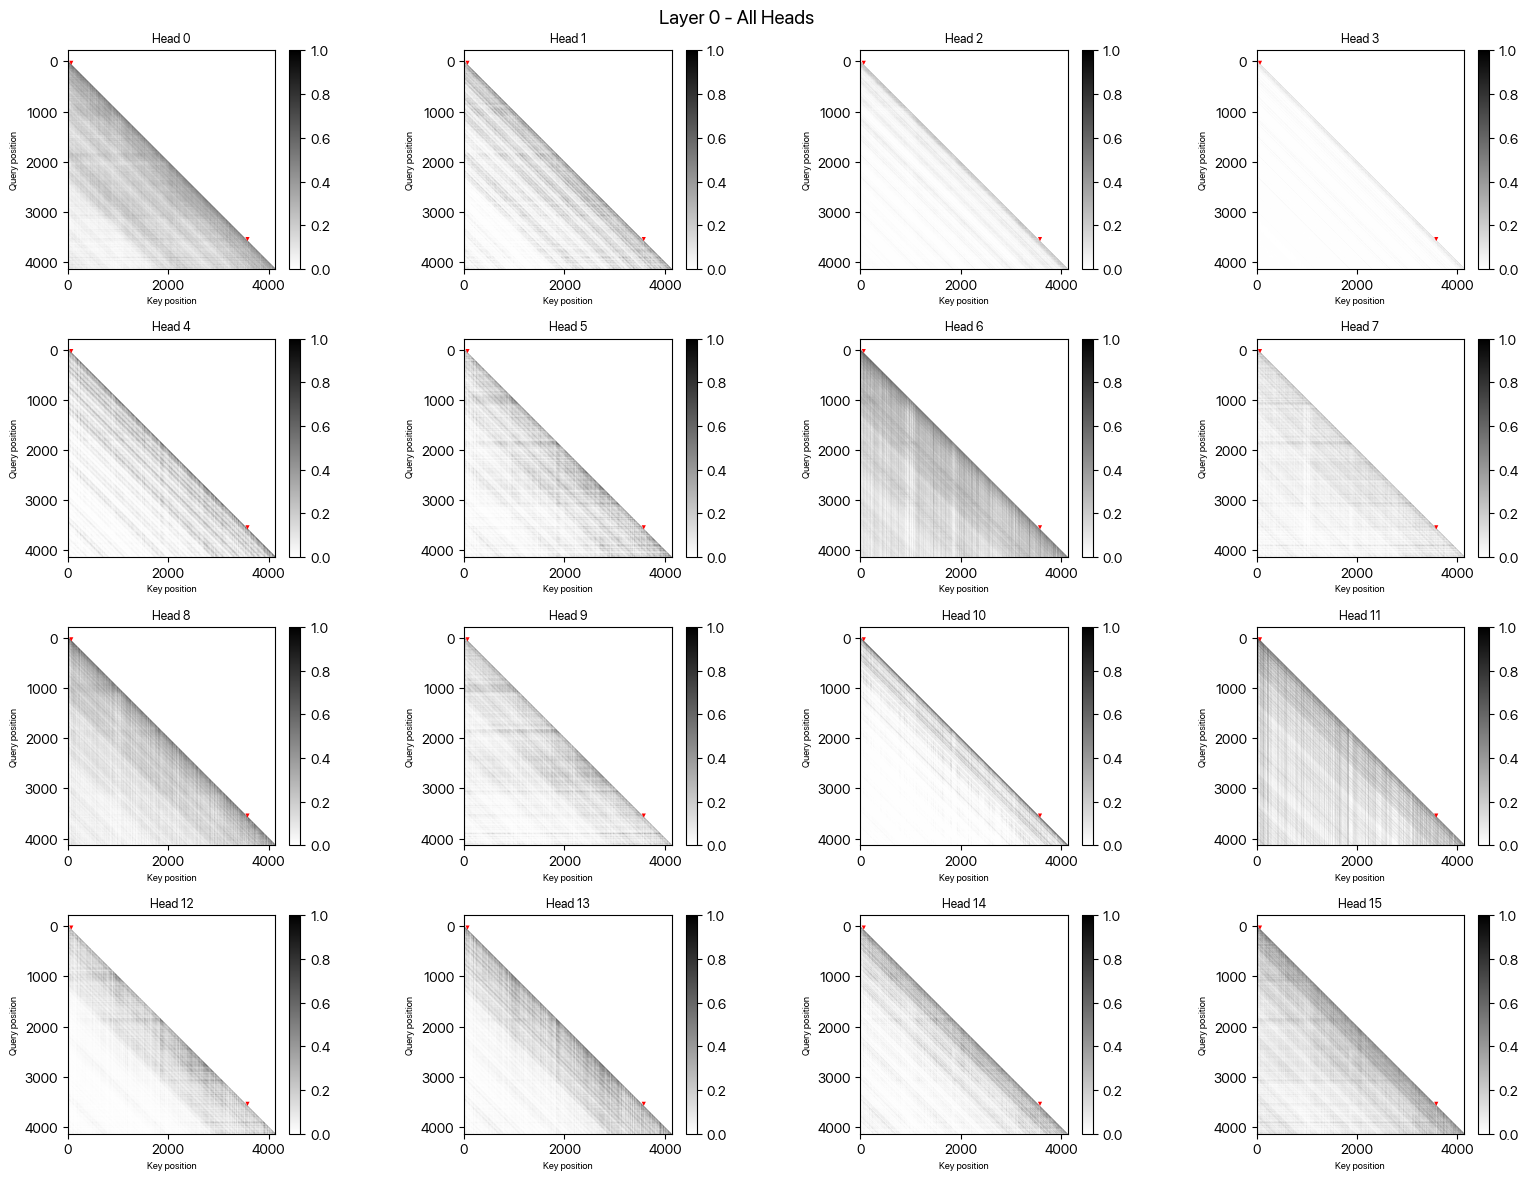

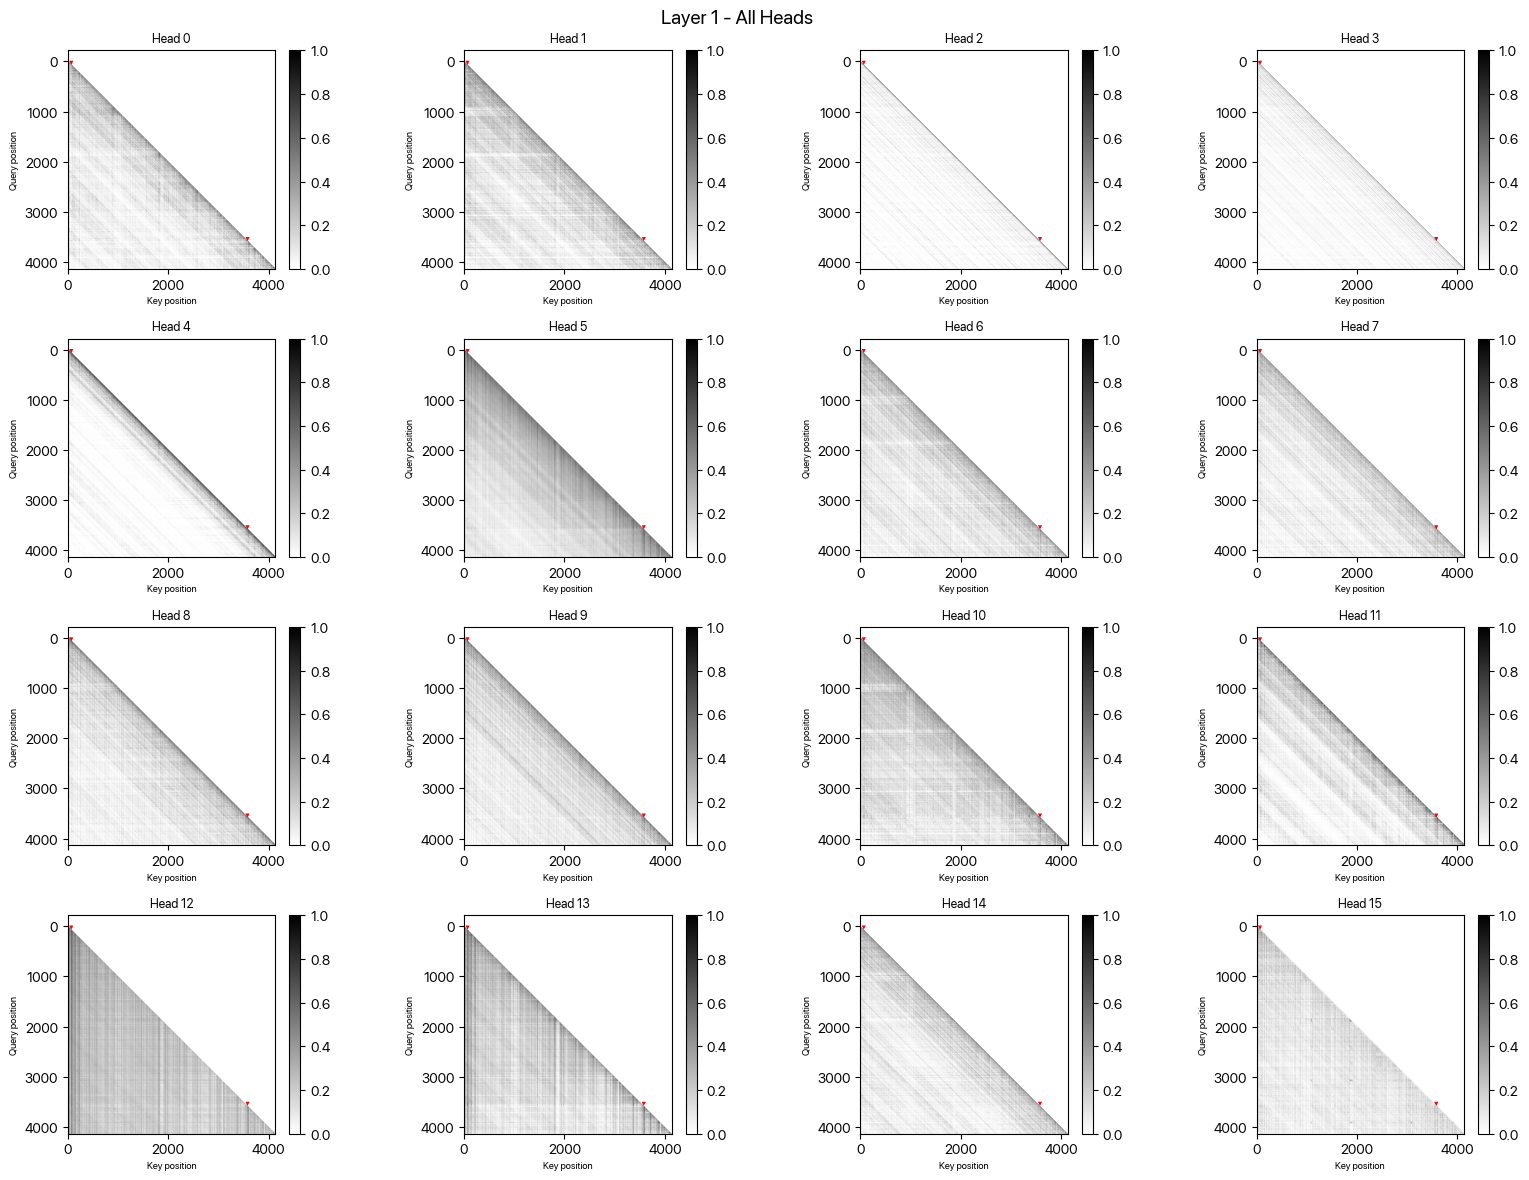

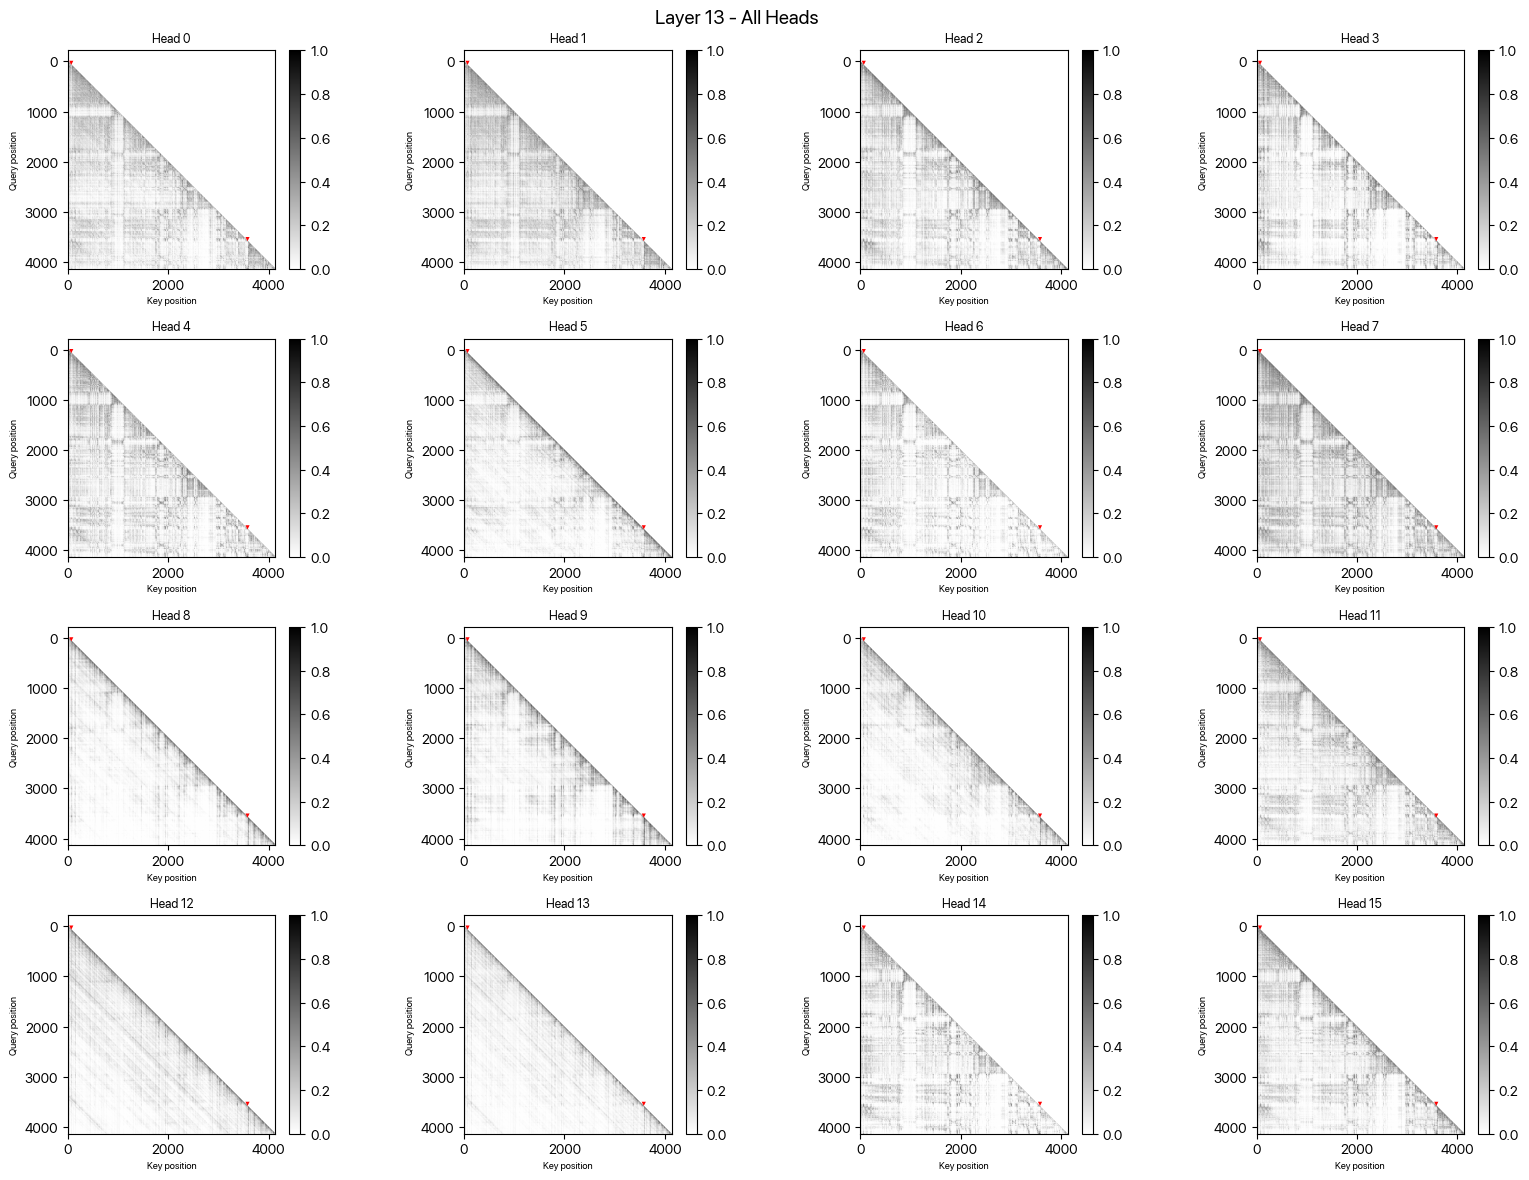

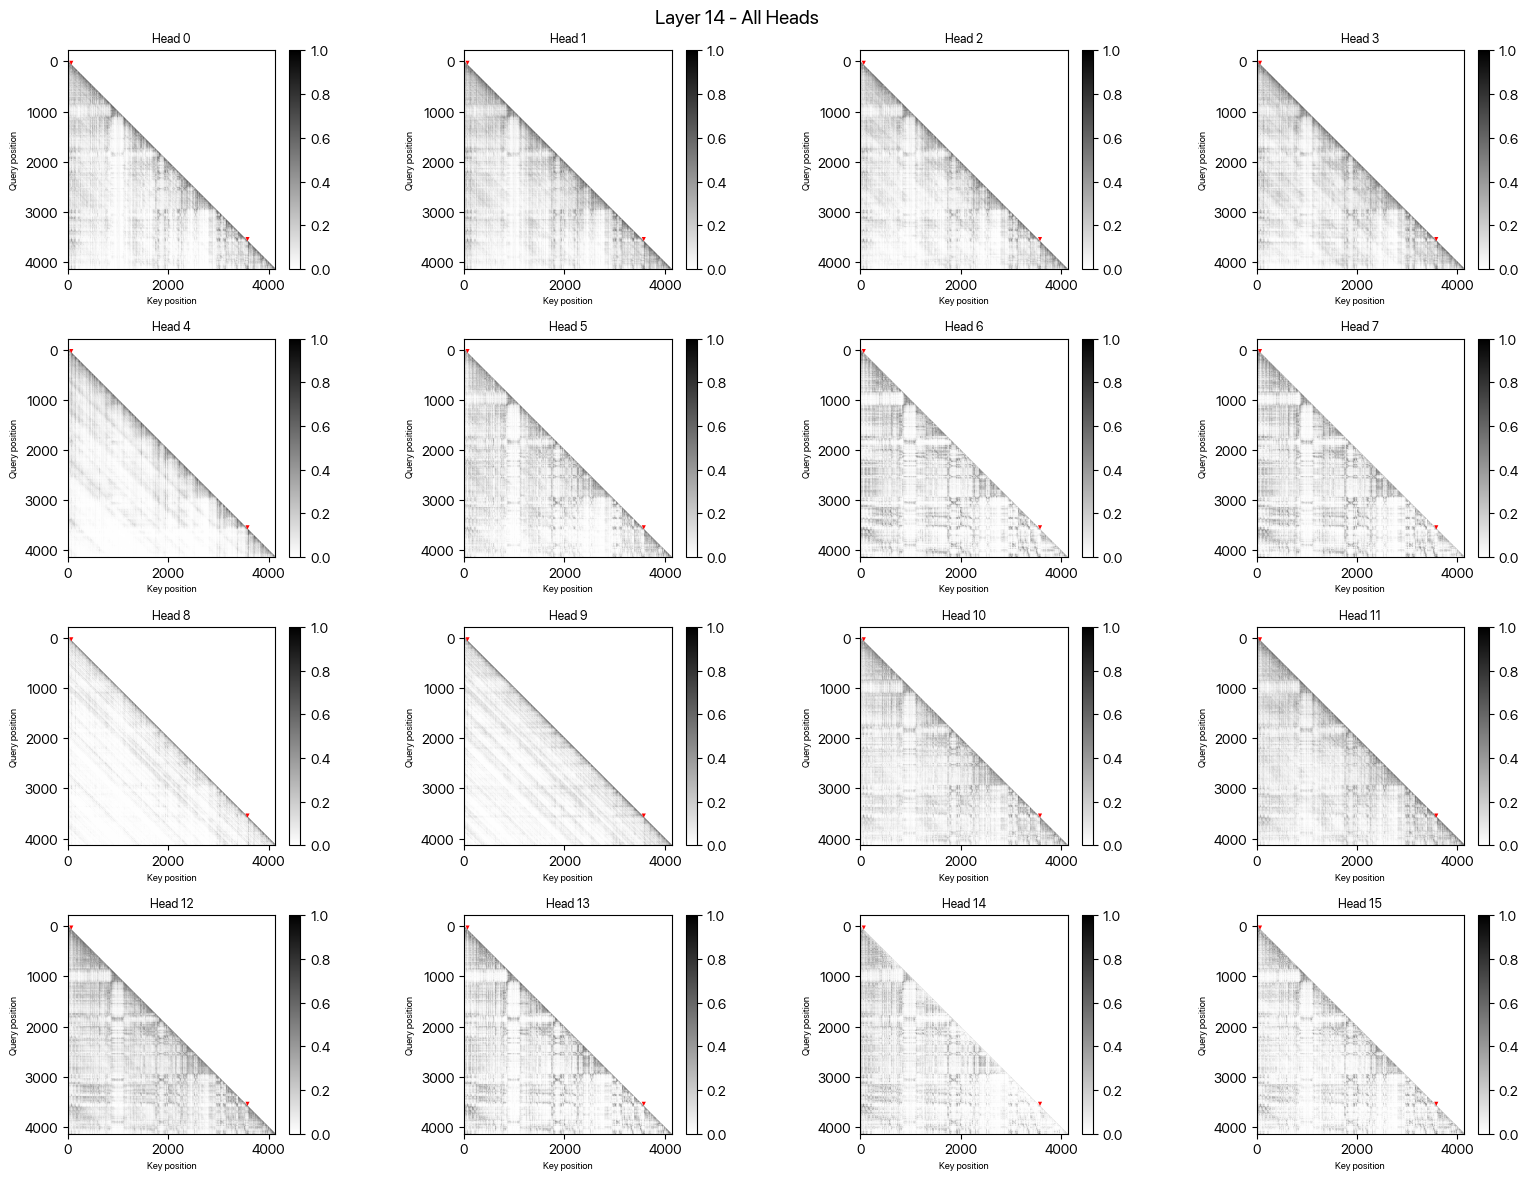

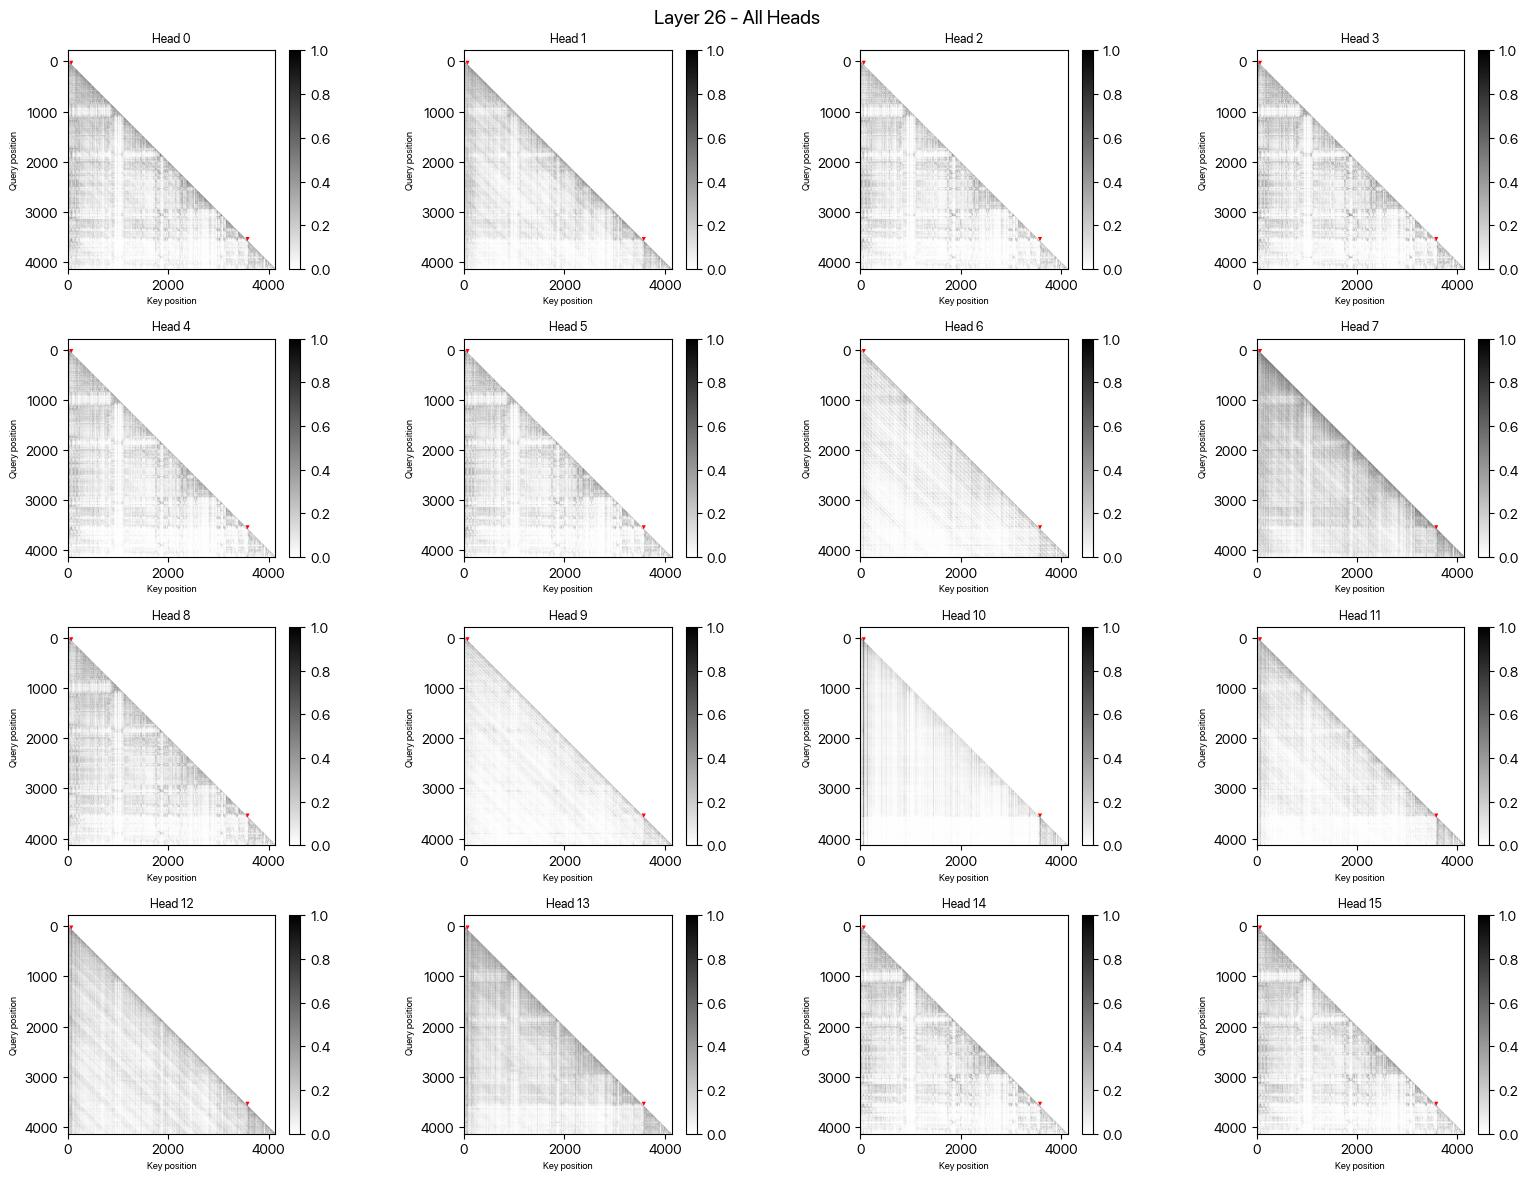

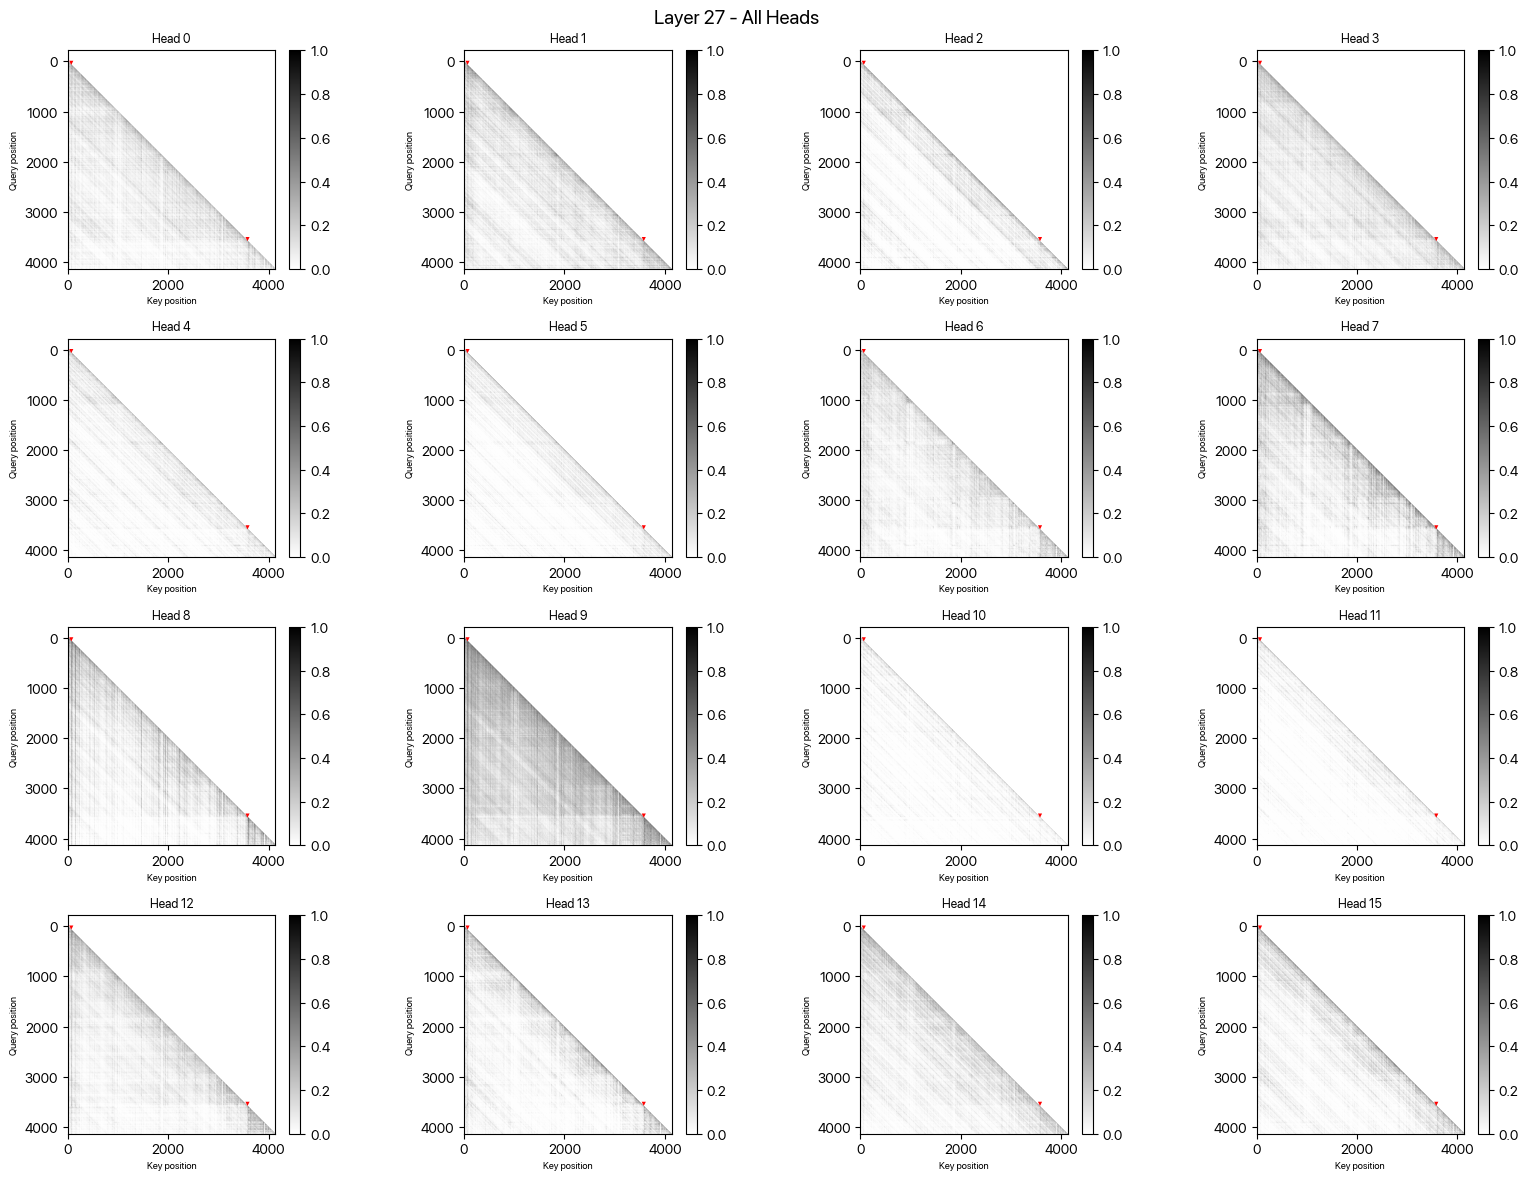

In [13]:
LAYERS_TO_SHOW = [0, 1, 13, 14, 26, 27]  # None = all layers, or list like [0, 1, 13, 14, 26, 27]

layers_to_visualize = range(num_layers) if LAYERS_TO_SHOW is None else LAYERS_TO_SHOW
special_positions = find_special_tokens(tokens)

print(f"Visualizing {len(list(layers_to_visualize))} layers, {num_heads} heads each...\n")

for layer_idx in layers_to_visualize:
    layer_attn = all_attentions[layer_idx].squeeze(0)  # [heads, seq, seq]
    cols = 4
    rows = (num_heads + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
    axes = axes.flatten()

    for head_idx in range(num_heads):
        ax = axes[head_idx]
        attn = layer_attn[head_idx].cpu().float().numpy()
        attn_transformed = apply_log_transform(attn)

        im = ax.imshow(attn_transformed, cmap='gray_r', aspect='equal', vmin=0, vmax=1)
        ax.grid(False)
        add_marker_triangles(ax, special_positions, len(tokens))
        ax.set_title(f'Head {head_idx}', fontsize=9, fontweight='bold')
        ax.set_xlabel('Key position', fontsize=7)
        ax.set_ylabel('Query position', fontsize=7)
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    for idx in range(num_heads, len(axes)):
        axes[idx].axis('off')

    fig.suptitle(f'Layer {layer_idx} - All Heads', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    plt.close(fig)

## Average Across All Heads (Configurable Layer)

Averaging heads for layer 27...


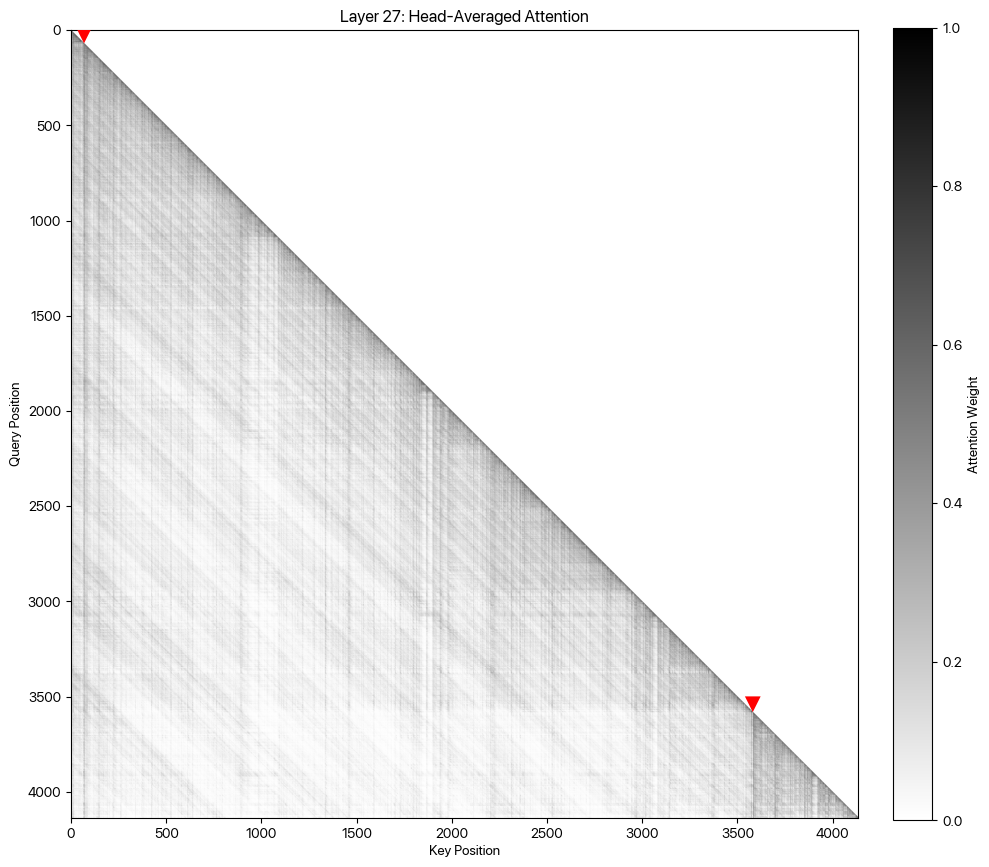

In [14]:
print(f"Averaging heads for layer {ATTENTION_LAYER}...")

layer_attn = all_attentions[ATTENTION_LAYER].squeeze(0)  # [heads, seq, seq]
avg_attn = layer_attn.mean(dim=0).cpu().float().numpy()   # [seq, seq]
avg_attn_transformed = apply_log_transform(avg_attn)

special_positions = find_special_tokens(tokens)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
im = ax.imshow(avg_attn_transformed, cmap='gray_r', aspect='equal', vmin=0, vmax=1)
add_marker_triangles(ax, special_positions, len(tokens))

ax.set_xlim(-0.5, len(tokens) - 0.5)
ax.set_ylim(len(tokens) - 0.5, -0.5)
ax.set_title(f'Layer {ATTENTION_LAYER}: Head-Averaged Attention', fontweight='bold', fontsize=12)
ax.set_xlabel('Key Position', fontsize=10)
ax.set_ylabel('Query Position', fontsize=10)
ax.grid(False)
plt.colorbar(im, ax=ax, label='Attention Weight', fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()
plt.close('all')

## Token Highlighting

In [19]:
def compute_token_weights(attention_data, tokens, epsilon=EPSILON, sigmoid_temperature=SIGMOID_TEMPERATURE):
    """
    Compute per-token attention weights using the grpo.py pipeline:
    log-transform -> z-score -> sigmoid -> min-max rescale.

    Args:
        attention_data: [seq, seq] numpy array (head-averaged attention for one layer)
        tokens: list of token strings
        epsilon: small constant for log transform
        sigmoid_temperature: controls contrast in sigmoid step

    Returns:
        attention_weights: list of floats [0, 1] per token (0 for non-reasoning tokens)
        think_start: index of <think>
        think_end: index of </think>
    """
    think_start = None
    think_end = None
    for i, token in enumerate(tokens):
        t = str(token)
        if t == '<think>' and think_start is None:
            think_start = i
        elif t == '</think>' and think_end is None:
            think_end = i

    weights = [0.0] * len(tokens)

    if think_start is None or think_end is None or think_start + 1 >= think_end:
        return weights, think_start, think_end

    chunk_start = think_start + 1
    chunk_end = think_end  # exclusive

    # Queries: everything from </think> onward
    query_start = think_end
    query_end = len(tokens)

    # Average attention from answer queries to each reasoning token
    avg_attention = np.mean(attention_data[query_start:query_end, chunk_start:chunk_end], axis=0)
    avg_attention_t = torch.from_numpy(avg_attention).float()

    # Step 1: Log transform
    log_attn = torch.log(avg_attention_t + epsilon)

    # Step 2: Z-score normalization
    seq_mean = log_attn.mean()
    seq_std = log_attn.std()

    if seq_std == 0:
        attn_transformed = torch.full_like(log_attn, 0.5)
    else:
        z_score = (log_attn - seq_mean) / seq_std
        # Step 3: Sigmoid with temperature
        attn_transformed = torch.sigmoid(z_score * sigmoid_temperature)

    # Step 4: Min-max rescale to [0, 1]
    min_w = attn_transformed.min()
    max_w = attn_transformed.max()
    if max_w > min_w:
        attn_transformed = (attn_transformed - min_w) / (max_w - min_w)
    else:
        attn_transformed = torch.full_like(attn_transformed, 0.5)

    # Assign to token positions
    for idx, pos in enumerate(range(chunk_start, chunk_end)):
        weights[pos] = attn_transformed[idx].item()

    return weights, think_start, think_end

def plot_token_highlighting(
    tokens,
    attention_weights,
    think_start,
    think_end,
    fig_width_in=8.0,
):
    """
    Render reasoning tokens with attention-weighted red highlighting.
    Figure height is computed dynamically to fit content.
    """
    bg_color = "#f5f5f7"
    text_color = "black"
    highlight_hex = "#ff3b2f"
    font_size_pt = 10
    line_spacing = 1.4

    MARGIN_PT = 5
    left_margin_pt = MARGIN_PT
    right_margin_pt = MARGIN_PT
    top_margin_pt = MARGIN_PT
    bottom_margin_pt = MARGIN_PT
    pad_y = font_size_pt * 0.10

    if os.path.exists(FONT_PATH):
        fm.fontManager.addfont(FONT_PATH)
        prop = fm.FontProperties(fname=FONT_PATH, size=font_size_pt)
    else:
        prop = fm.FontProperties(size=font_size_pt)

    if think_start is None or think_end is None or think_start + 1 >= think_end:
        print("No valid <think>...</think> section found.")
        return None

    chunk_start = think_start + 1
    chunk_end = think_end - 1

    # Build display items: (text, weight) pairs
    chunk_tokens = [str(tokens[i]) for i in range(chunk_start, chunk_end + 1)]
    chunk_token_ids = [tokenizer.convert_tokens_to_ids(tok) for tok in chunk_tokens]
    full_text = tokenizer.decode(chunk_token_ids, skip_special_tokens=False)

    items = []
    char_pos = 0
    for idx, tok_id in enumerate(chunk_token_ids):
        decoded_so_far = tokenizer.decode(chunk_token_ids[:idx+1], skip_special_tokens=False)
        next_char_pos = len(decoded_so_far)
        token_text = full_text[char_pos:next_char_pos]
        weight = attention_weights[chunk_start + idx]
        for p in re.split(r"(\n)", token_text):
            if not p:
                continue
            if p == "\n":
                items.append(("\\n", weight))
            else:
                items.append((p, weight))
        char_pos = next_char_pos

    def sanitize(t):
        return t.replace("$", r"\$")

    line_step = font_size_pt * line_spacing

    # First pass: measure content height
    temp_fig, temp_ax = plt.subplots(figsize=(fig_width_in, 100.0))
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    temp_ax.set_position([0, 0, 1, 1])
    temp_ax.axis('off')
    temp_fig.canvas.draw()
    temp_renderer = temp_fig.canvas.get_renderer()
    PX2PT = 72.0 / temp_fig.dpi

    def measure_text_pts(t, renderer):
        w_px, h_px, d_px = renderer.get_text_width_height_descent(t, prop, ismath=False)
        return (w_px * PX2PT, (h_px - d_px) * PX2PT, d_px * PX2PT)

    temp_axbb = temp_ax.get_window_extent(renderer=temp_renderer)
    W_pts = temp_axbb.width * PX2PT
    max_line_w = W_pts - left_margin_pt - right_margin_pt

    _, temp_asc, temp_des = measure_text_pts(sanitize("Mg"), temp_renderer)

    y_current = 0.0
    x = 0.0
    for raw_text, weight in items:
        t_disp = sanitize(raw_text)
        w_pt, _, _ = measure_text_pts(t_disp, temp_renderer)
        if (x + w_pt) > max_line_w and x > 0:
            y_current -= line_step
            x = 0.0
        x += w_pt
    plt.close(temp_fig)

    content_height_pt = abs(y_current) + temp_asc + temp_des
    fig_height_pt = content_height_pt + top_margin_pt + bottom_margin_pt
    fig_height_in = fig_height_pt / 72.0

    # Final figure
    fig, ax = plt.subplots(figsize=(fig_width_in, fig_height_in))
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    ax.set_position([0, 0, 1, 1])
    fig.patch.set_facecolor(bg_color)
    ax.set_facecolor(bg_color)
    ax.axis('off')

    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()

    axbb = ax.get_window_extent(renderer=renderer)
    W_pts = axbb.width * PX2PT
    H_pts = axbb.height * PX2PT
    ax.set_xlim(0, W_pts)
    ax.set_ylim(0, H_pts)

    _, FIX_ASC, FIX_DES = measure_text_pts(sanitize("Mg"), renderer)
    FIX_HEIGHT = FIX_ASC + FIX_DES

    x0 = left_margin_pt
    y = H_pts - top_margin_pt - FIX_ASC
    max_line_w = W_pts - left_margin_pt - right_margin_pt

    x = x0
    for raw_text, weight in items:
        t_disp = sanitize(raw_text)
        w_pt, _, _ = measure_text_pts(t_disp, renderer)

        if (x - x0 + w_pt) > max_line_w and x > x0:
            y -= line_step
            x = x0

        if weight > 0.0:
            rect_x = x
            rect_y = y - FIX_DES - pad_y
            rect_w = w_pt
            rect_h = FIX_HEIGHT + 2 * pad_y
            alpha = weight * 0.9
            ax.add_patch(Rectangle((rect_x, rect_y), rect_w, rect_h,
                                   facecolor=highlight_hex, alpha=alpha,
                                   edgecolor='none'))

        ax.text(x, y, t_disp, color=text_color, fontproperties=prop,
                va='baseline', ha='left')
        x += w_pt

    return fig

<think> at 69, </think> at 3581
Reasoning tokens: 3511
Weight range: [0.0033, 1.0000]


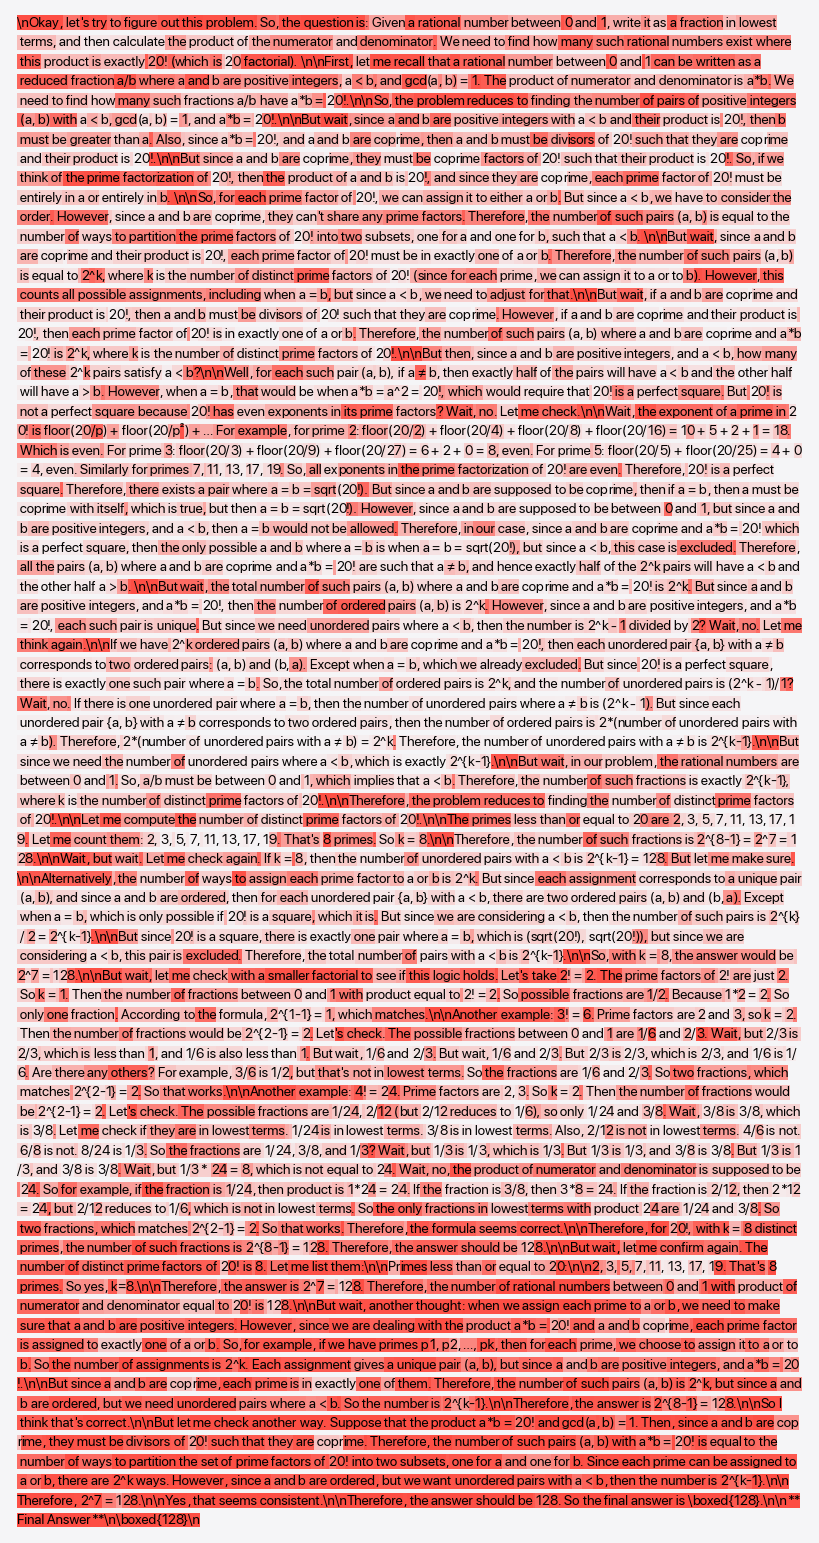

In [21]:
# Compute weights using grpo.py normalization pipeline
layer_attn = all_attentions[ATTENTION_LAYER].squeeze(0)  # [heads, seq, seq]
avg_attn_np = layer_attn.mean(dim=0).cpu().float().numpy()  # [seq, seq]

attention_weights, think_start, think_end = compute_token_weights(
    avg_attn_np, tokens,
    epsilon=EPSILON,
    sigmoid_temperature=SIGMOID_TEMPERATURE,
)

reasoning_len = (think_end - think_start - 1) if (think_start is not None and think_end is not None) else 0
print(f"<think> at {think_start}, </think> at {think_end}")
print(f"Reasoning tokens: {reasoning_len}")
print(f"Weight range: [{min(w for w in attention_weights if w > 0):.4f}, {max(attention_weights):.4f}]")

fig = plot_token_highlighting(tokens, attention_weights, think_start, think_end)
if fig is not None:
    plt.show()
    plt.close(fig)

## High Attention Score Tokens

In [17]:
if think_start is not None and think_end is not None and think_start + 1 < think_end:
    chunk_start = think_start + 1
    chunk_end = think_end
    think_section_length = chunk_end - chunk_start

    token_data = []
    for token_pos in range(chunk_start, chunk_end):
        token_str = str(tokens[token_pos])
        token_id = tokenizer.convert_tokens_to_ids(token_str)
        token_text = tokenizer.decode([token_id])

        position_in_think = token_pos - think_start
        progression_pct = int(np.ceil((position_in_think / think_section_length) * 100))

        token_data.append({
            'Attention_Score': attention_weights[token_pos],
            'Token': token_text,
            'Token_ID': token_id,
            'Position': position_in_think,
            'Progression_%': progression_pct,
        })

    df = pd.DataFrame(token_data)
    df = df.sort_values('Attention_Score', ascending=False).reset_index(drop=True)

    top_50 = df.head(50)[['Attention_Score', 'Token', 'Token_ID', 'Position', 'Progression_%']]

    print(f"Top 50 tokens by attention score in <think> section (Layer {ATTENTION_LAYER}):")
    print(f"Total reasoning tokens: {think_section_length}")
    print(f"Normalization: log -> z-score -> sigmoid(T={SIGMOID_TEMPERATURE}) -> min-max\n")

    pd.set_option('display.max_rows', 50)
    pd.set_option('display.max_colwidth', 40)
    pd.set_option('display.float_format', lambda x: f'{x:.4f}')
    display(top_50)
else:
    print("No valid <think>...</think> section found.")

Top 50 tokens by attention score in <think> section (Layer 27):
Total reasoning tokens: 3511
Normalization: log -> z-score -> sigmoid(T=2.0) -> min-max



Attention_Score        Token  Token_ID  Position  Progression_%
0            1.0000       Answer     21806      3503            100
1            1.0000          }\n       532      3511            100
2            1.0000            ,        11         3              1
3            1.0000         **\n      1019      3504            100
4            1.0000         Okay     32313         2              1
5            1.0000        .\n\n       382      3500            100
6            1.0000            8        23      3510            100
7            1.0000        .\n\n       382      3476            100
8            0.9999        .\n\n       382      3458             99
9            0.9999         \n\n      4710        77              3
10           0.9999        .\n\n       382      3293             94
11           0.9999        .\n\n       382      3300             94
12           0.9999        .\n\n       382      2944             84
13           0.9999        .\n\n       382      3470             99
14           0.9998            .        13      3487            100
15           0.9998        .\n\n       382      3069             88
16           0.9998           **       334      3501            100
17           0.9997        .\n\n       382      3275             94
18           0.9997           of       315      3362             96
19           0.9997        .\n\n       382      2899             83
20           0.9996            .        13      3427             98
21           0.9996        .\n\n       382      2133             61
22           0.9995          the       279      3310             95
23           0.9995        Final     19357      3502            100
24           0.9994            8        23      3498            100
25           0.9994          the       279      3360             96
26           0.9994          the       279      3387             97
27           0.9994            \        59      3505            100
28           0.9993       !.\n\n     98527      3208             92
29           0.9993           to       311      3385             97
30           0.9992            .        13      3408             98
31           0.9991         such      1741      3363             96
32           0.9990            .        13      3307             95
33           0.9990   consistent     12966      3475             99
34           0.9990           of       315      3043             87
35           0.9990           of       315      3383             97
36           0.9989          way      1616      3306             95
37           0.9989            }        92      3499            100
38           0.9988            .        13      2933             84
39           0.9986        boxed     79075      3506            100
40           0.9985         each      1817      3410             98
41           0.9984            .        13      3357             96
42           0.9984            .        13      3328             95
43           0.9983            .        13      3038             87
44           0.9982            \      1124      3493            100
45           0.9980        .\n\n       382      2457             70
46           0.9980      another      2441      3305             95
47           0.9980          the       279      3489            100
48           0.9979          the       279      3479            100
49           0.9978          and       323      3319             95